In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.color import rgb2gray
import pywt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns

import torch

from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader

In [2]:
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

PyTorch Version: 2.6.0+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 2
CUDA Device Name: NVIDIA RTX A6000


In [3]:
model_name = "SAM_ViT_B_parihaka"
height, width = 1006, 590 # parihaka
train_path = Path("/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images")
annotation_path = Path("/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations")

train_img_reader = TiffReader(train_path / "train")
train_label_reader = PNGReader(annotation_path / "train")

sample -> min: 0.0 | max: 1.0
sample shape: (1006, 531)
label -> min: 0 | max: 5
label shape: (1006, 531)
lbp_masked -> min: 0.0 | max: 1.0
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.88888889 0.88888889 0.88888889 ... 0.         0.22222222 0.44444444]
 [0.88888889 0.88888889 0.88888889 ... 0.44444444 0.33333333 0.33333333]
 [0.11111111 0.         0.11111111 ... 0.44444444 0.88888889 0.88888889]]


/home/vscode/.local/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


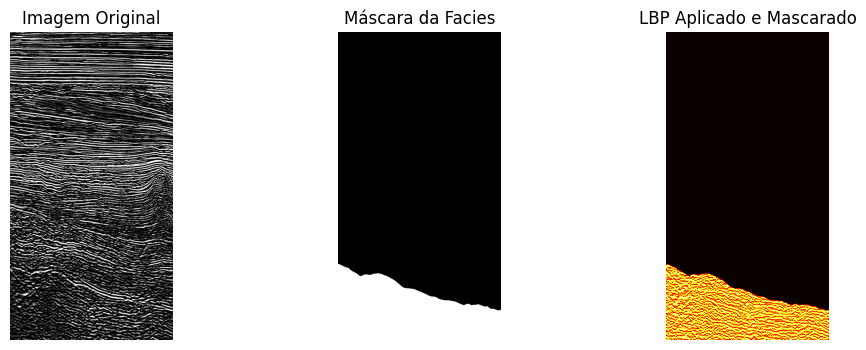

lbp_masked -> min: 0.0 | max: 1.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


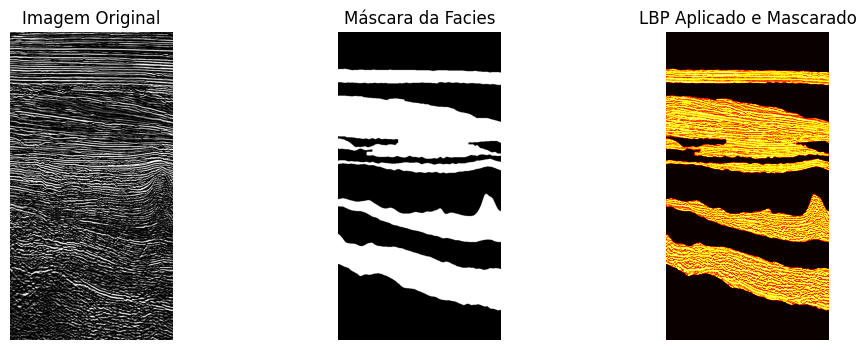

lbp_masked -> min: 0.0 | max: 1.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


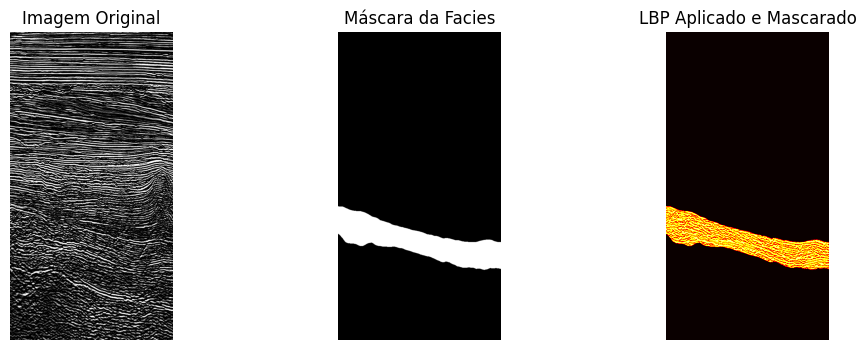

lbp_masked -> min: 0.0 | max: 1.0
[[0.         0.11111111 0.11111111 ... 0.33333333 0.88888889 0.88888889]
 [0.22222222 0.44444444 0.44444444 ... 0.88888889 0.88888889 0.88888889]
 [0.33333333 0.88888889 0.88888889 ... 0.88888889 0.88888889 0.88888889]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


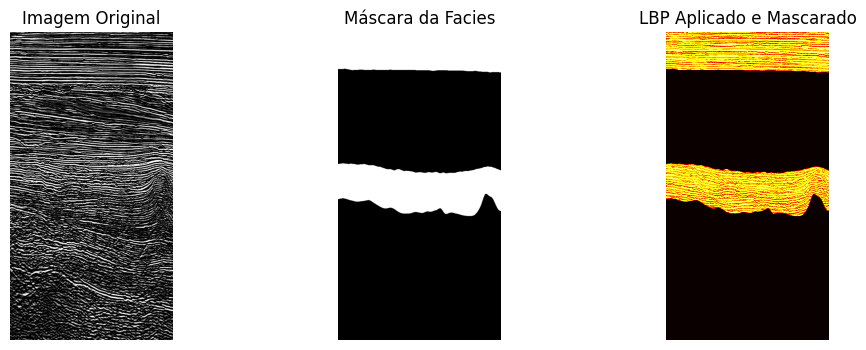

lbp_masked -> min: 0.0 | max: 1.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


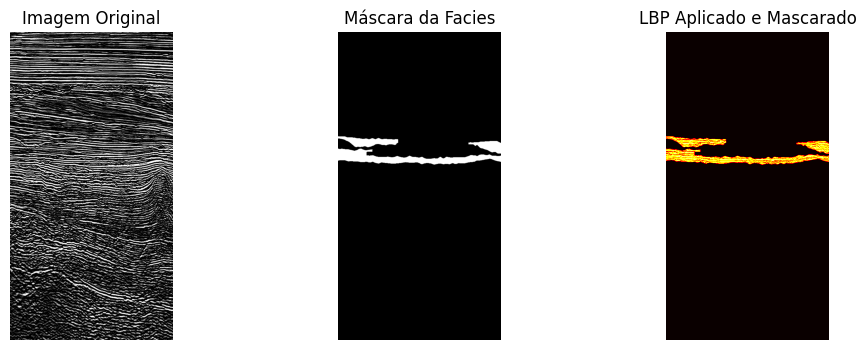

lbp_masked -> min: 0.0 | max: 1.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


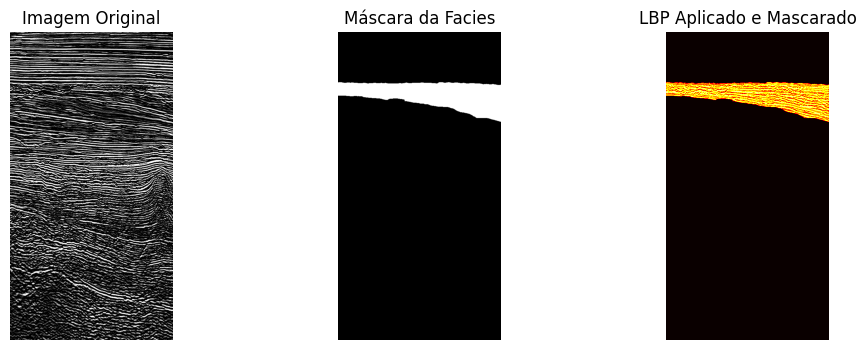

In [11]:
sample = train_img_reader[0]
label = train_label_reader[0]

sample = np.clip(sample * 255, 0, 255).astype(np.uint8)
sample = rgb2gray(sample)

print(f"sample -> min: {np.min(sample)} | max: {np.max(sample)}")
print(f"sample shape: {sample.shape}")
print(f"label -> min: {np.min(label)} | max: {np.max(label)}")
print(f"label shape: {label.shape}")

num_facies = np.unique(label)
for facie in num_facies:
    region = np.zeros_like(label, dtype=np.uint8) # [H,W]
    region[label == facie] = 1

    # Parâmetros do LBP
    radius = 1
    n_points = 8 * radius  # Geralmente 8 pontos para raio 1

    lbp = local_binary_pattern(sample, n_points, radius, method='uniform')

    # Normaliza o LBP para a faixa [0, 1]
    lbp_normalized = (lbp - lbp.min()) / (lbp.max() - lbp.min())

    # Aplica a máscara da facies: mantém os valores de LBP apenas na região da facies alvo
    lbp_masked = lbp_normalized * region
    print(f"lbp_masked -> min: {np.min(lbp_masked)} | max: {np.max(lbp_masked)}")
    print(lbp_masked)

    # Visualiza os resultados
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(sample, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(region, cmap='gray')
    plt.title('Máscara da Facies')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(lbp_masked, cmap='hot')
    plt.title('LBP Aplicado e Mascarado')
    plt.axis('off')

    plt.show()

In [4]:
def etapa_2(labels, facies_mask, amplitude_image):
    # Dicionário para armazenar as estatísticas de cada facies
    statistics = {}

    for label in labels:
        # Cria uma máscara booleana para a facies atual
        mask = facies_mask == label
        # Extrai os pixels correspondentes à facies
        pixels = amplitude_image[mask]
        
        # Calcula estatísticas básicas
        stats = {
            'mean': np.mean(pixels),
            'std': np.std(pixels),
            'skewness': skew(pixels),
            'kurtosis': kurtosis(pixels),
            'histogram': np.histogram(pixels, bins=30)  # histogram (bins e frequências)
        }
        statistics[label] = stats
        
    #     # Plot do histograma
    #     plt.figure()
    #     plt.hist(pixels.flatten(), bins=30, color='blue', alpha=0.7)
    #     plt.title(f'Histograma de amplitudes para Facies {label}')
    #     plt.xlabel('Amplitude')
    #     plt.ylabel('Frequência')
    #     plt.show()

    # # Exibe as estatísticas calculadas para cada facies
    # for label, stats in statistics.items():
    #     print(f'Facies {label}:')
    #     print(stats)
    #     print('------------------------')
    return statistics

In [5]:
def etapa_3a(labels, facies_mask, amplitude_image):
    # Parâmetros do GLCM
    distances = [1]  # distância de 1 pixel
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    levels = 256  # número de níveis (supondo imagem em 8 bits)

    glcm_features = {}

    for label in labels:
        mask = facies_mask == label
        # Para manter a estrutura espacial, extraímos a caixa delimitadora dos pixels da facies
        coords = np.argwhere(mask)
        min_row, min_col = coords.min(axis=0)
        max_row, max_col = coords.max(axis=0)
        region_img = amplitude_image[min_row:max_row+1, min_col:max_col+1]
        
        gray_img = rgb2gray(region_img)  # Converte para escala de cinza
        gray_img = (gray_img * 255).astype(np.uint8)  # Normaliza para 8 bits
        
        # Calcula a matriz de coocorrência
        glcm = graycomatrix(gray_img, distances=distances, angles=angles,
                            levels=levels, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast').mean()
        homogeneity = graycoprops(glcm, 'homogeneity').mean()
        energy = graycoprops(glcm, 'energy').mean()
        correlation = graycoprops(glcm, 'correlation').mean()
        
        glcm_features[label] = {
            'contrast': contrast,
            'homogeneity': homogeneity,
            'energy': energy,
            'correlation': correlation
        }
        
        # print(f'Facies {label} - GLCM Features: {glcm_features[label]}')
    return glcm_features

def etapa_3b(labels, facies_mask, amplitude_image):
    lbp_features = {}

    # Parâmetros para LBP
    radius = 1
    n_points = 8 * radius

    for label in labels:
        mask = facies_mask == label
        coords = np.argwhere(mask)
        min_row, min_col = coords.min(axis=0)
        max_row, max_col = coords.max(axis=0)
        region_img = amplitude_image[min_row:max_row+1, min_col:max_col+1]

        gray_img = rgb2gray(region_img)  # Converte para escala de cinza
        gray_img = (gray_img * 255).astype(np.uint8)  # Normaliza para 8 bits
        
        # Calcula o LBP
        lbp = local_binary_pattern(gray_img, n_points, radius, method='uniform')
        
        # Calcula o histograma do LBP
        lbp_hist, _ = np.histogram(lbp, density=True, bins=np.arange(0, n_points + 3))
        lbp_features[label] = lbp_hist
        
        # # Plot da imagem LBP
        # plt.figure()
        # plt.imshow(lbp, cmap='gray')
        # plt.title(f'LBP para Facies {label}')
        # plt.colorbar()
        # plt.show()
        
        # print(f'Facies {label} - LBP Histogram: {lbp_features[label]}')
    return lbp_features

In [6]:
def etapa_4(labels, facies_mask, amplitude_image):
    frequency_features = {}

    for label in labels:
        mask = facies_mask == label
        coords = np.argwhere(mask)
        min_row, min_col = coords.min(axis=0)
        max_row, max_col = coords.max(axis=0)
        region_img = amplitude_image[min_row:max_row+1, min_col:max_col+1]

        gray_img = rgb2gray(region_img)  # Converte para escala de cinza
        gray_img = (gray_img * 255).astype(np.uint8)  # Normaliza para 8 bits
        
        # Transformada de Fourier
        f = np.fft.fft2(gray_img) # or region_img to rgb image
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-8)  # Adiciona um pequeno valor para evitar log(0)
        
        # Decomposição Wavelet usando a transformada discreta de Haar
        coeffs2 = pywt.dwt2(gray_img, 'haar') # or region_img to rgb image
        cA, (cH, cV, cD) = coeffs2  # cA é a aproximação, os demais são detalhes
        
        frequency_features[label] = {
            'fft_magnitude_mean': np.mean(magnitude_spectrum),
            'wavelet_approx_mean': np.mean(cA)
        }
        
        # # Plot do espectro de Fourier
        # plt.figure()
        # plt.imshow(magnitude_spectrum, cmap='gray')
        # plt.title(f'Espectro de Frequência para Facies {label}')
        # plt.colorbar()
        # plt.show()
        
        # # Plot do coeficiente de aproximação da Wavelet
        # plt.figure()
        # plt.imshow(cA, cmap='gray')
        # plt.title(f'Coeficiente de Aproximação Wavelet para Facies {label}')
        # plt.colorbar()
        # plt.show()
        
        # print(f'Facies {label} - Frequency Features: {frequency_features[label]}')
    return frequency_features

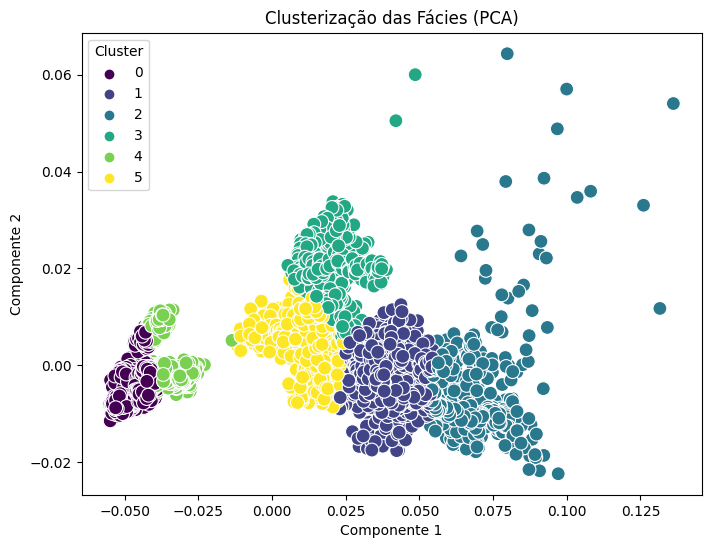

Amostra da Facies 0 pertence ao cluster 3
Amostra da Facies 1 pertence ao cluster 5
Amostra da Facies 2 pertence ao cluster 5
Amostra da Facies 3 pertence ao cluster 1
Amostra da Facies 4 pertence ao cluster 3
Amostra da Facies 5 pertence ao cluster 1
Amostra da Facies 0 pertence ao cluster 3
Amostra da Facies 1 pertence ao cluster 5
Amostra da Facies 2 pertence ao cluster 5
Amostra da Facies 3 pertence ao cluster 1
Amostra da Facies 4 pertence ao cluster 5
Amostra da Facies 5 pertence ao cluster 1
Amostra da Facies 0 pertence ao cluster 3
Amostra da Facies 1 pertence ao cluster 5
Amostra da Facies 2 pertence ao cluster 5
Amostra da Facies 3 pertence ao cluster 1
Amostra da Facies 4 pertence ao cluster 1
Amostra da Facies 5 pertence ao cluster 2
Amostra da Facies 0 pertence ao cluster 5
Amostra da Facies 1 pertence ao cluster 1
Amostra da Facies 2 pertence ao cluster 1
Amostra da Facies 3 pertence ao cluster 2
Amostra da Facies 4 pertence ao cluster 1
Amostra da Facies 5 pertence ao cl

In [7]:
# Inicializa listas para acumular os vetores de características e os rótulos correspondentes
global_feature_matrix = []
global_labels = []

# Loop por todas as amostras
for amplitude_image, facies_mask in zip(train_img_reader, train_label_reader):
    labels = np.unique(facies_mask)

    # Etapa 2: Análise Estatística de Amplitudes
    statistics = etapa_2(labels, facies_mask, amplitude_image)
    
    # Etapa 3: Extração de Características Texturais
    glcm_features = etapa_3a(labels, facies_mask, amplitude_image)
    lbp_features = etapa_3b(labels, facies_mask, amplitude_image)
    
    # Etapa 4: Análise de Frequência e Multiescala
    frequency_features = etapa_4(labels, facies_mask, amplitude_image)
    
    # Para cada facies na amostra, extraímos o vetor de características
    for label in labels:
        # Converter arrays de skewness e kurtosis para listas planas
        skewness_vals = np.array(statistics[label]['skewness']).flatten().tolist() if isinstance(statistics[label]['skewness'], (np.ndarray, list)) else [statistics[label]['skewness']]
        kurtosis_vals = np.array(statistics[label]['kurtosis']).flatten().tolist() if isinstance(statistics[label]['kurtosis'], (np.ndarray, list)) else [statistics[label]['kurtosis']]
        # Converter o histograma LBP para lista
        lbp_vals = np.array(lbp_features[label]).flatten().tolist() if isinstance(lbp_features[label], (np.ndarray, list)) else [lbp_features[label]]
        
        # Monta o vetor de características combinando os valores
        features = [
            # statistics[label]['mean'],
            # statistics[label]['std'],
            # *skewness_vals,
            # *kurtosis_vals,
            # *glcm_features[label].values(),  # contrast, homogeneity, energy, correlation
            *lbp_vals,                       # histograma LBP
            # *frequency_features[label].values()  # fft_magnitude_mean, wavelet_approx_mean
        ]
        global_feature_matrix.append(features)
        global_labels.append(label)

# Converte a matriz de características global para array NumPy garantindo tipo float
global_feature_matrix = np.array(global_feature_matrix, dtype=float)

# Escolha do método de redução de dimensionalidade: PCA ou t-SNE
method = 'PCA'  # ou 'TSNE'
if method == 'PCA':
    reducer = PCA(n_components=2)
else:
    reducer = TSNE(n_components=2, perplexity=5, random_state=42)

reduced_features = reducer.fit_transform(global_feature_matrix)

# Clusterização com K-Means (número de clusters igual ao número de facies únicas)
n_clusters = len(np.unique(global_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(global_feature_matrix)

# Plot dos clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=clusters, palette="viridis", s=100)
plt.title(f'Clusterização das Fácies ({method})')
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Cluster")
plt.show()

# Exibe os grupos encontrados para cada vetor acumulado (você pode também agrupar por facies, se necessário)
for idx, label in enumerate(global_labels):
    print(f'Amostra da Facies {label} pertence ao cluster {clusters[idx]}')

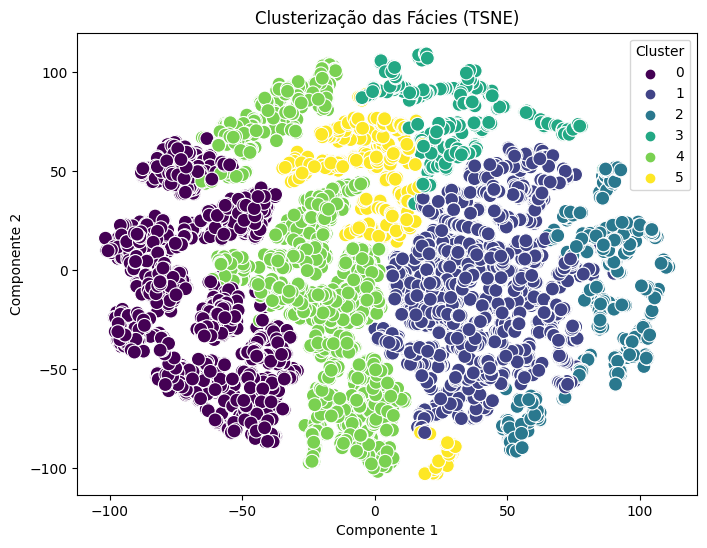

Amostra da Facies 0 pertence ao cluster 3
Amostra da Facies 1 pertence ao cluster 5
Amostra da Facies 2 pertence ao cluster 5
Amostra da Facies 3 pertence ao cluster 1
Amostra da Facies 4 pertence ao cluster 3
Amostra da Facies 5 pertence ao cluster 1
Amostra da Facies 0 pertence ao cluster 3
Amostra da Facies 1 pertence ao cluster 5
Amostra da Facies 2 pertence ao cluster 5
Amostra da Facies 3 pertence ao cluster 1
Amostra da Facies 4 pertence ao cluster 5
Amostra da Facies 5 pertence ao cluster 1
Amostra da Facies 0 pertence ao cluster 3
Amostra da Facies 1 pertence ao cluster 5
Amostra da Facies 2 pertence ao cluster 5
Amostra da Facies 3 pertence ao cluster 1
Amostra da Facies 4 pertence ao cluster 1
Amostra da Facies 5 pertence ao cluster 2
Amostra da Facies 0 pertence ao cluster 5
Amostra da Facies 1 pertence ao cluster 1
Amostra da Facies 2 pertence ao cluster 1
Amostra da Facies 3 pertence ao cluster 2
Amostra da Facies 4 pertence ao cluster 1
Amostra da Facies 5 pertence ao cl

In [8]:
# Escolha do método de redução de dimensionalidade: PCA ou t-SNE
method = 'TSNE'  # ou 'TSNE'
if method == 'PCA':
    reducer = PCA(n_components=2)
else:
    reducer = TSNE(n_components=2, perplexity=5, random_state=42)

reduced_features = reducer.fit_transform(global_feature_matrix)

# Clusterização com K-Means (número de clusters igual ao número de facies únicas)
n_clusters = len(np.unique(global_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(global_feature_matrix)

# Plot dos clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=clusters, palette="viridis", s=100)
plt.title(f'Clusterização das Fácies ({method})')
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Cluster")
plt.show()

# Exibe os grupos encontrados para cada vetor acumulado (você pode também agrupar por facies, se necessário)
for idx, label in enumerate(global_labels):
    print(f'Amostra da Facies {label} pertence ao cluster {clusters[idx]}')

Acurácia por validação cruzada: [0.97022901 0.96641221 0.95877863 0.95877863 0.96791444]
Acurácia média: 0.9644225823570233

Relatório de Classificação (Treino/Teste):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       337
           1       0.96      0.99      0.97       336
           2       0.99      0.93      0.96       336
           3       0.97      0.98      0.97       337
           4       0.94      0.96      0.95       283
           5       0.93      0.92      0.92       336

    accuracy                           0.96      1965
   macro avg       0.96      0.96      0.96      1965
weighted avg       0.96      0.96      0.96      1965

Matriz de Confusão:
[[336   0   1   0   0   0]
 [  0 332   0   0   0   4]
 [  3   1 314   0  10   8]
 [  0   0   0 331   0   6]
 [  0   3   3   0 271   6]
 [  0  10   0  12   6 308]]


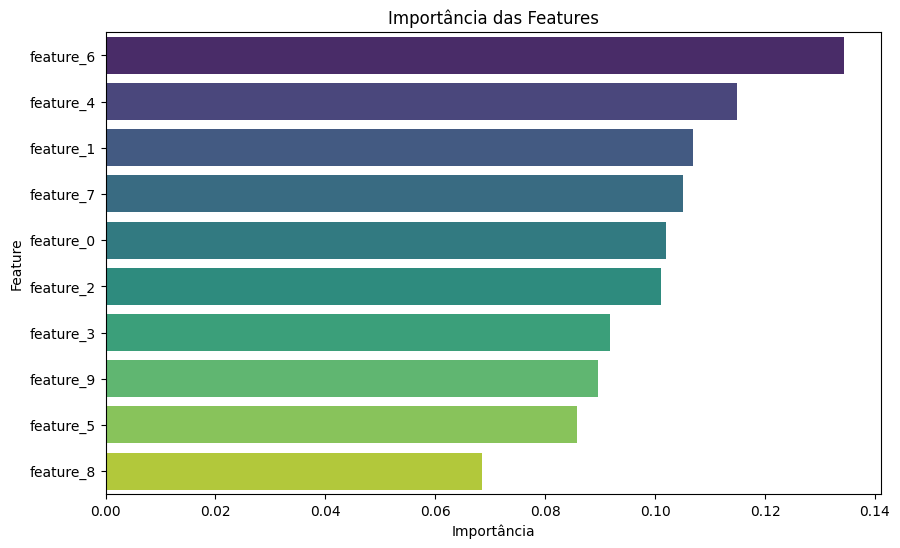

In [9]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que global_feature_matrix e global_labels já estejam definidos:
# global_feature_matrix: numpy array shape (n_amostras, n_features)
# global_labels: lista ou array dos rótulos correspondentes a cada amostra

X = global_feature_matrix  # Matriz de features
y = np.array(global_labels)  # Rótulos (facies)

# 1. Desempenho em Tarefas Supervisionadas

# a) Avaliação por Validação Cruzada (StratifiedKFold para preservar a proporção de classes)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Calcula acurácia para cada fold
cv_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
print("Acurácia por validação cruzada:", cv_scores)
print("Acurácia média:", np.mean(cv_scores))

# b) Divisão Treino/Teste para obter relatório detalhado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nRelatório de Classificação (Treino/Teste):")
print(classification_report(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# 2. Análise de Importância das Features

# Treina o modelo usando todo o conjunto para obter as importâncias
clf.fit(X, y)
importances = clf.feature_importances_

# Se não tivermos nomes específicos para as features, criamos nomes genéricos
feature_names = [f"feature_{i}" for i in range(X.shape[1])]

# Ordena as importâncias de forma decrescente
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")
plt.title("Importância das Features")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()

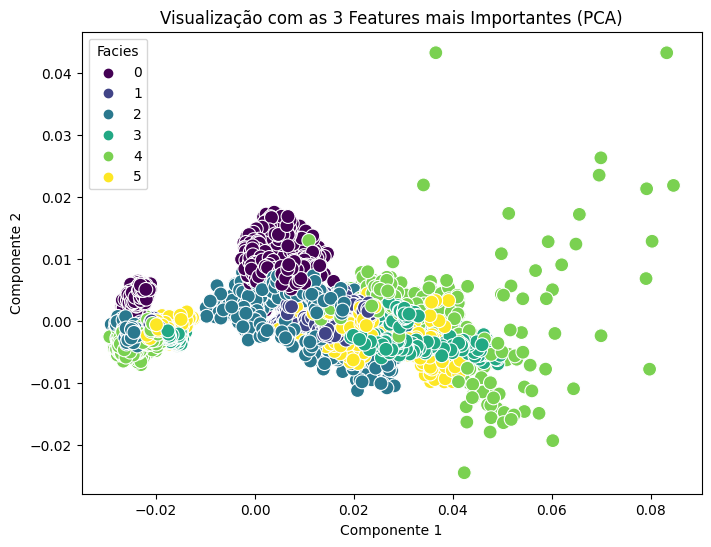

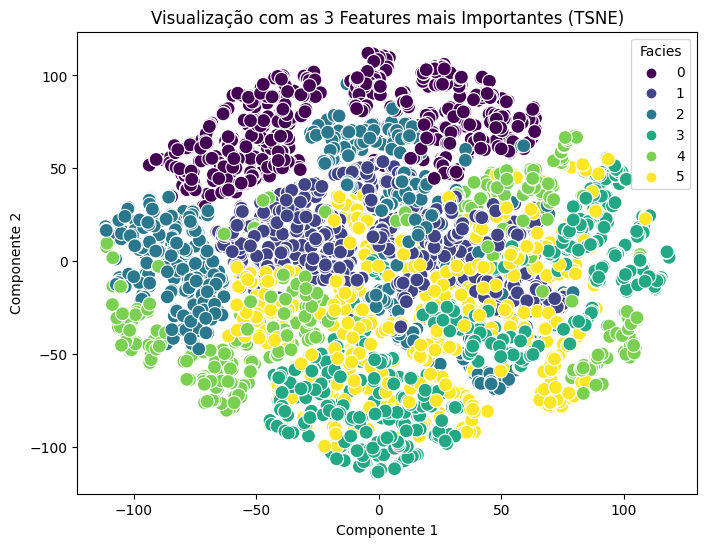

In [10]:
# 'importances' é o vetor de importâncias obtido do modelo
top3_indices = np.argsort(importances)[-3:][::-1]  # Índices das 3 maiores importâncias
X_top3 = X[:, top3_indices]  # Seleciona as 3 features mais importantes

method = 'PCA'
# Aplicando PCA ou t-SNE nos dados reduzidos
if method == 'PCA':
    reducer = PCA(n_components=2)
else:
    reducer = TSNE(n_components=2, perplexity=5, random_state=42)

reduced_features_top3 = reducer.fit_transform(X_top3)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features_top3[:, 0], y=reduced_features_top3[:, 1], hue=y, palette="viridis", s=100)
plt.title(f'Visualização com as 3 Features mais Importantes ({method})')
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Facies")
plt.show()

# 'importances' é o vetor de importâncias obtido do modelo
top3_indices = np.argsort(importances)[-3:][::-1]  # Índices das 3 maiores importâncias
X_top3 = X[:, top3_indices]  # Seleciona as 3 features mais importantes

method = 'TSNE'
# Aplicando PCA ou t-SNE nos dados reduzidos
if method == 'PCA':
    reducer = PCA(n_components=2)
else:
    reducer = TSNE(n_components=2, perplexity=5, random_state=42)

reduced_features_top3 = reducer.fit_transform(X_top3)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features_top3[:, 0], y=reduced_features_top3[:, 1], hue=y, palette="viridis", s=100)
plt.title(f'Visualização com as 3 Features mais Importantes ({method})')
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Facies")
plt.show()